In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import category_encoders as ce
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, PowerTransformer

from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
train_raw, test_raw = pd.read_csv('~/Downloads/house-pricing/train.csv'), pd.read_csv('~/Downloads/house-pricing/test.csv')

In [3]:

# Street, Utilities, Condition2, RoofMatl: bad repartition
# Alley, PoolQC: most are missing


# MasVnrArea, BsmtFinSF1, 2ndFlrSF, LowQualFinSF, PoolArea: Had a lot of 0.0
date_related = ['GarageYrBlt', 'MoSold', 'YrSold']
boolean = ['CentralAir']
target = 'SalePrice'
to_drop = ['Id', 'PoolArea', 'PoolQC', 'YearBuilt', 'YearRemodAdd']

numerical = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
             'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
             'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'OverallCond', 'OverallQual'] + date_related
categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
              'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
              'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
              'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']  + boolean

assert len(categorical )+ len(numerical) + len(to_drop) + 1 == train_raw.shape[1]
assert set(categorical + numerical + date_related + boolean + [target] + to_drop) == set(train_raw.columns)



In [6]:
train = train_raw.copy()
train['LivibleRatio'] = train['1stFlrSF'] / train['LotArea']
train['HasMasVnr'] = train['MasVnrArea'] == 0
train['BuildingAge'] = 2020 - train['YearBuilt']
train['LastRemodling'] = 2020 - train['YearRemodAdd']
train['HasPool'] = train['PoolArea'] > 0
train['BuiltPercentage'] = train['1stFlrSF'] / train['LotArea']
train['DiffBuitSold'] = train['YearBuilt'] - train['YrSold']
train['AvrRoomSF'] = train['TotRmsAbvGrd'] / (train['1stFlrSF'] + train['2ndFlrSF'])
train['2ndfloorPercentage'] = train['2ndFlrSF'] / train['1stFlrSF']
train['HasBasment'] = train['TotalBsmtSF'] > 0
train['DiffRemodBuilt'] = train['YearRemodAdd'] - train['YearBuilt']

test = test_raw.copy()
test['LivibleRatio'] = test['1stFlrSF'] / test['LotArea']
test['HasMasVnr'] = test['MasVnrArea'] == 0
test['BuildingAge'] = 2020 - test['YearBuilt']
test['LastRemodling'] = 2020 - test['YearRemodAdd']
test['HasPool'] = test['PoolArea'] > 0
test['BuiltPercentage'] = test['1stFlrSF'] / test['LotArea']
test['DiffBuitSold'] = test['YearBuilt'] - test['YrSold']
test['AvrRoomSF'] = test['TotRmsAbvGrd'] / (test['1stFlrSF'] + test['2ndFlrSF'])
test['2ndfloorPercentage'] = test['2ndFlrSF'] / test['1stFlrSF']
test['HasBasment'] = test['TotalBsmtSF'] > 0
test['DiffRemodBuilt'] = test['YearRemodAdd'] - test['YearBuilt']



engineered = ['TotalArea', 'LivibleRatio', 'HasMasVnr', 'BuildingAge', 'LastRemodling', 'HasPool', 'BuiltPercentage', 'DiffBuitSold', 'AvrRoomSF',
             '2ndfloorPercentage', 'HasBasment', 'DiffRemodBuilt']

to_normalize = ['DiffBuitSold', 'BuildingAge', 'LastRemodling', 'DiffRemodBuilt']
train = train.drop(columns=to_drop, axis=1)
test = test.drop(columns=to_drop, axis=1)

In [7]:
# Finding discrete variables

discrete = []
for var in numerical:
    if len(train[var].unique())<20:
        print(var, ' values: ', train[var].unique())
        discrete.append(var)
        
print('There are {} discrete variables'.format(len(discrete)))

BsmtFullBath  values:  [1 0 2 3]
BsmtHalfBath  values:  [0 1 2]
FullBath  values:  [2 1 3 0]
HalfBath  values:  [1 0 2]
BedroomAbvGr  values:  [3 4 1 2 0 5 6 8]
KitchenAbvGr  values:  [1 2 3 0]
TotRmsAbvGrd  values:  [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces  values:  [0 1 2 3]
GarageCars  values:  [2 3 1 0 4]
OverallCond  values:  [5 8 6 7 4 2 3 9 1]
OverallQual  values:  [ 7  6  8  5  9  4 10  3  1  2]
MoSold  values:  [ 2  5  9 12 10  8 11  4  1  7  3  6]
YrSold  values:  [2008 2007 2006 2009 2010]
There are 13 discrete variables


In [8]:
# Missing values:
mostly_missing = list()
treshold = 0.8
for var in train.columns:
    missing_prc =  train[var].isna().mean()
    if missing_prc > treshold:
        print(f"{var}: {train[var].unique()}, {missing_prc}.")
        mostly_missing.append(var)

Alley: [nan 'Grvl' 'Pave'], 0.9376712328767123.
Fence: [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw'], 0.8075342465753425.
MiscFeature: [nan 'Shed' 'Gar2' 'Othr' 'TenC'], 0.963013698630137.


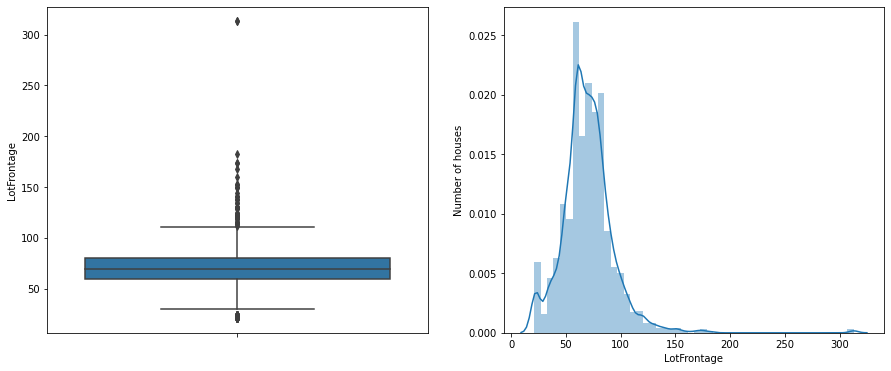

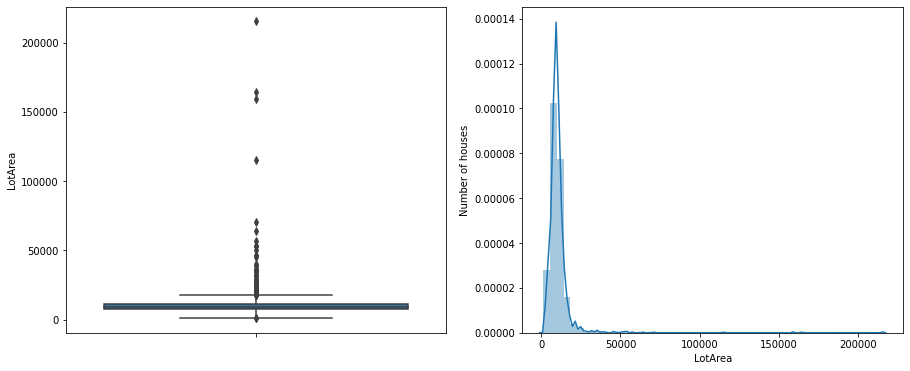

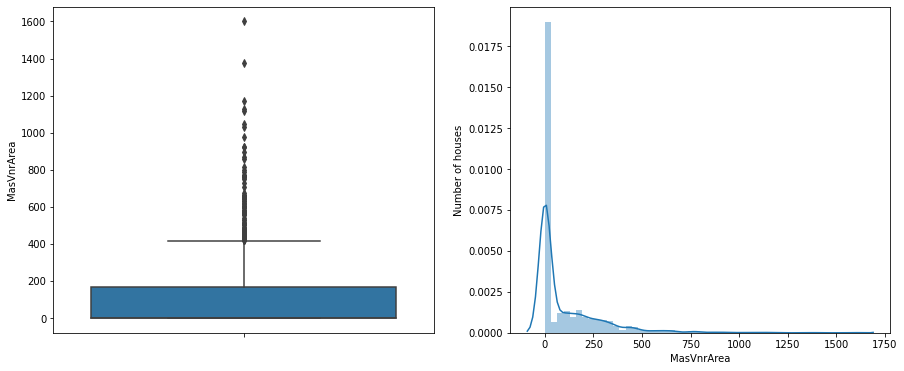

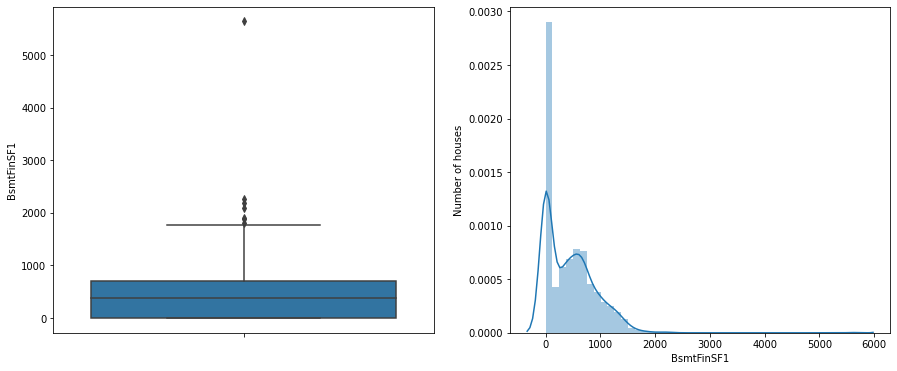

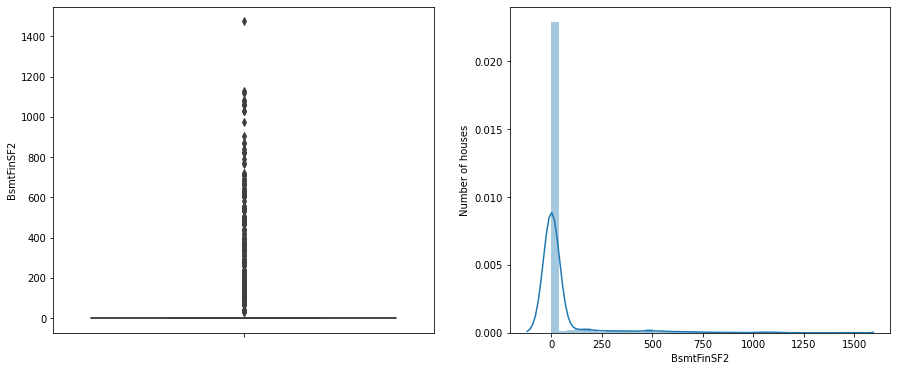

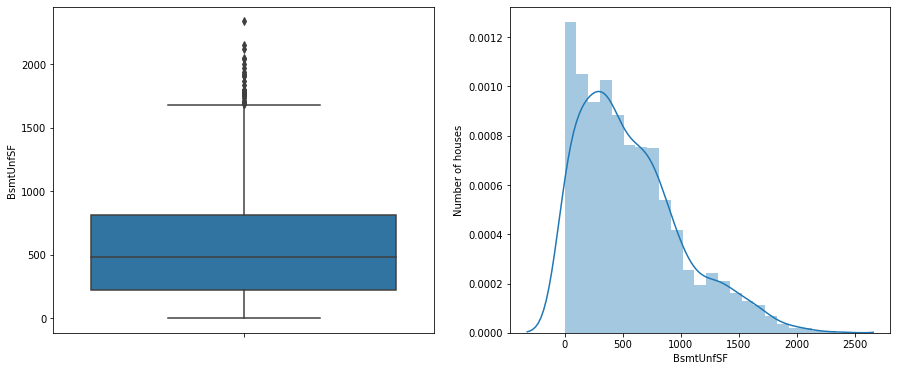

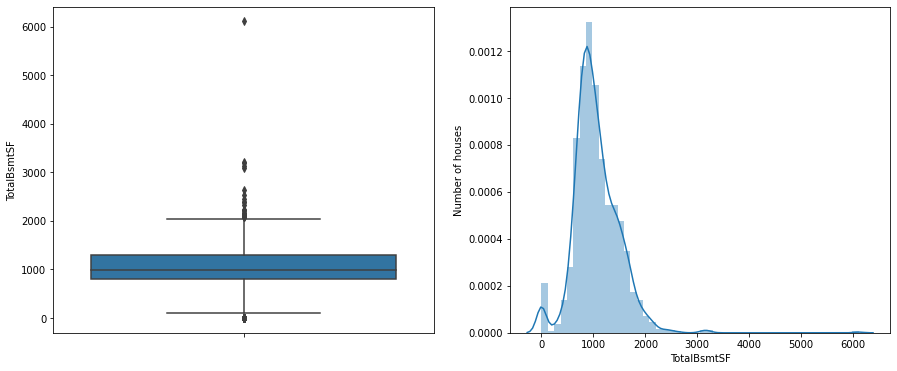

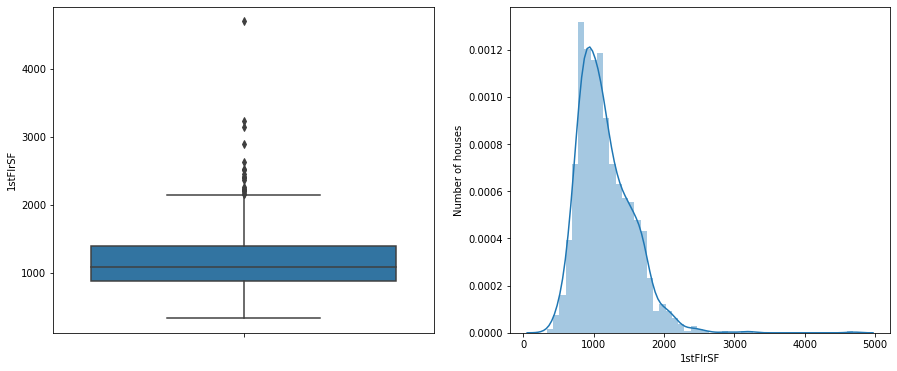

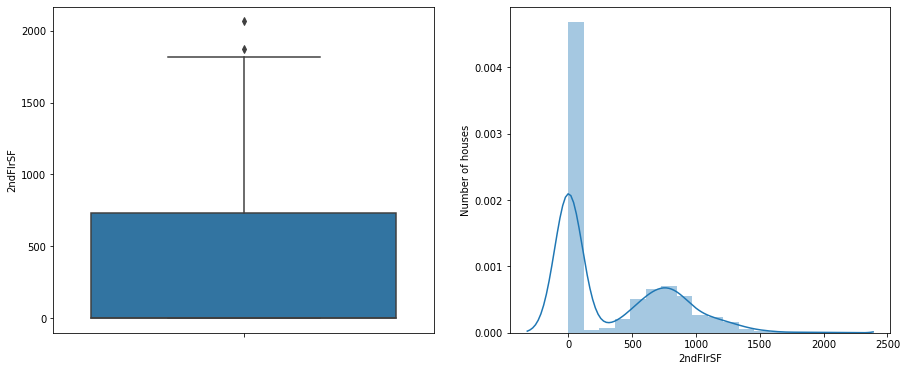

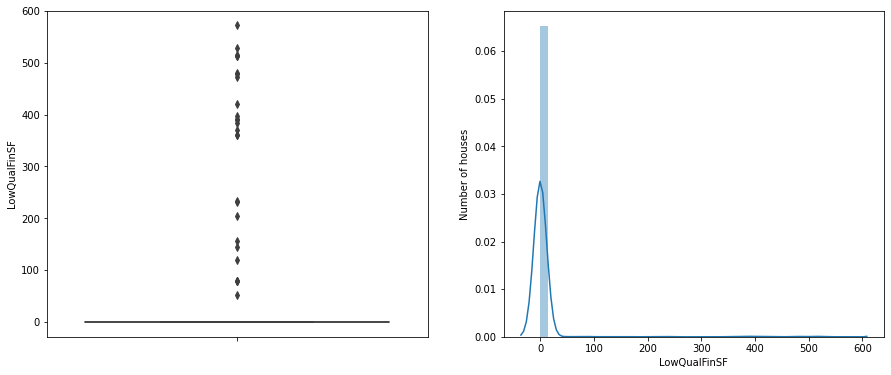

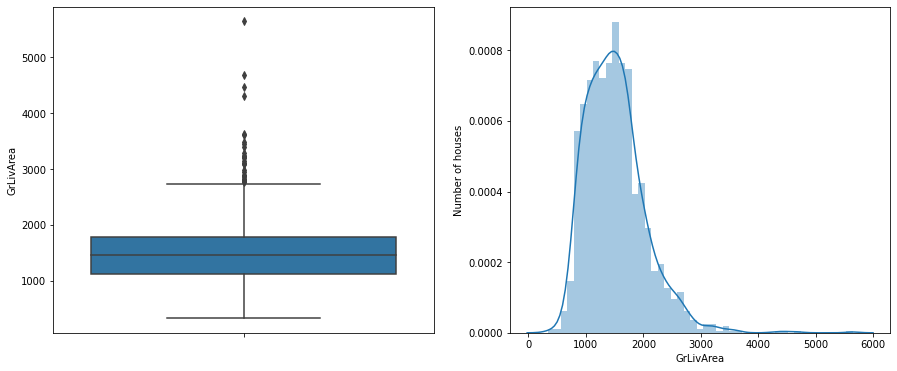

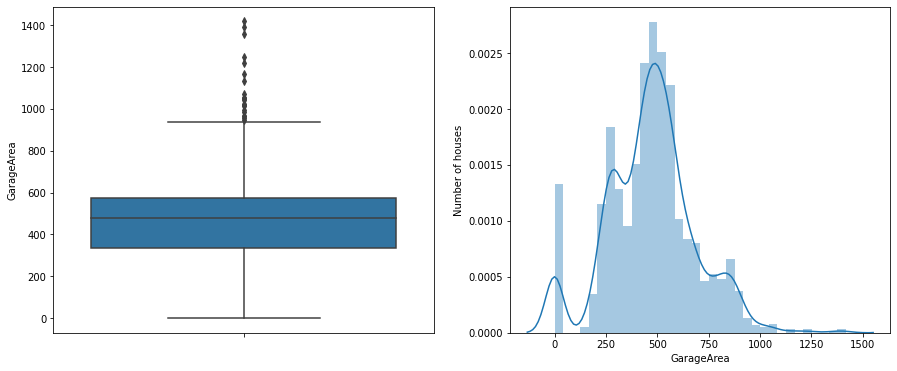

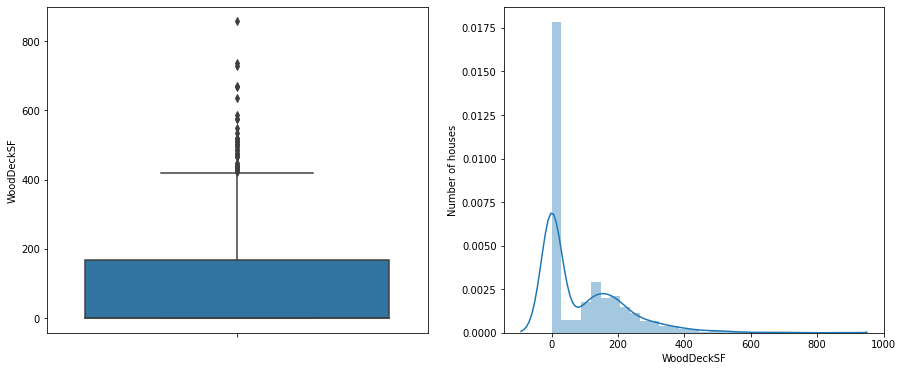

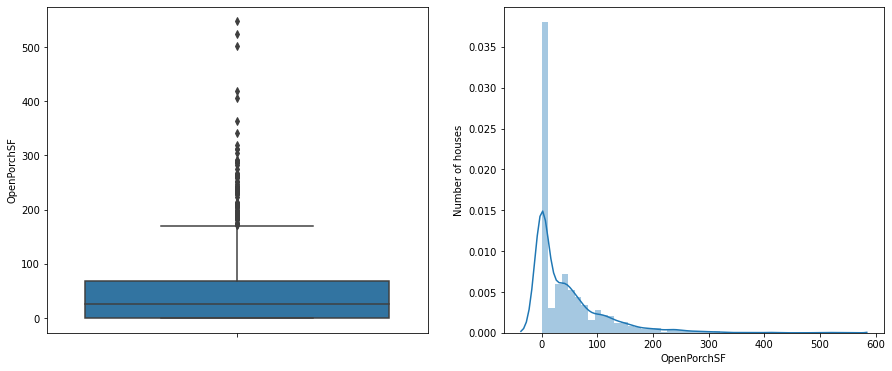

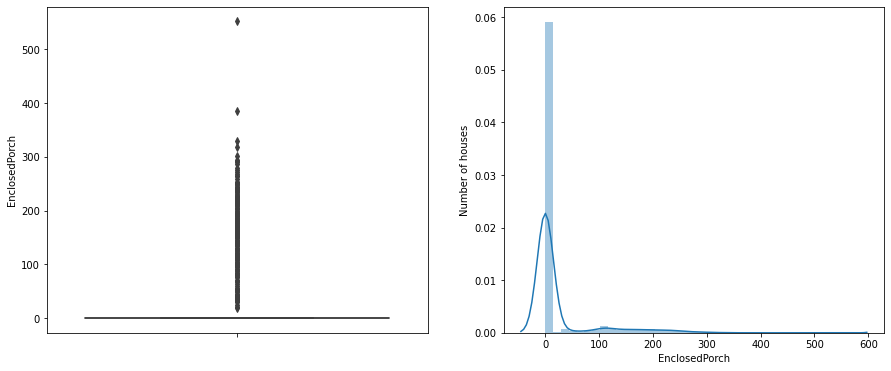

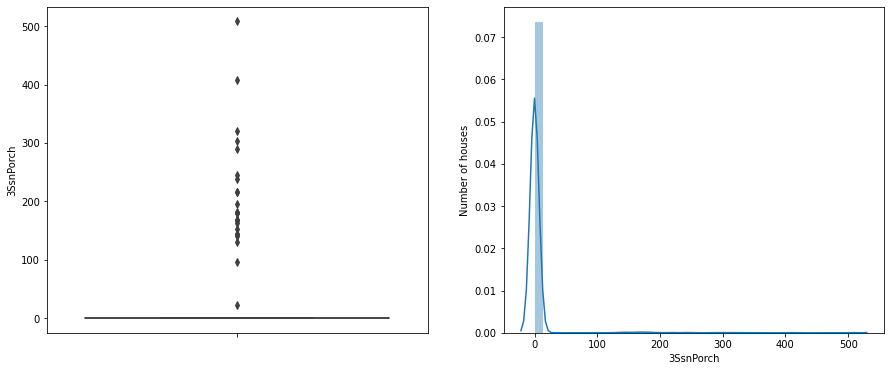

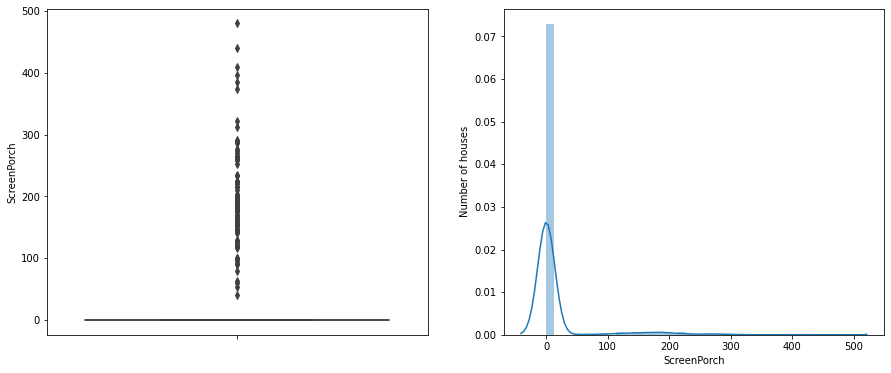

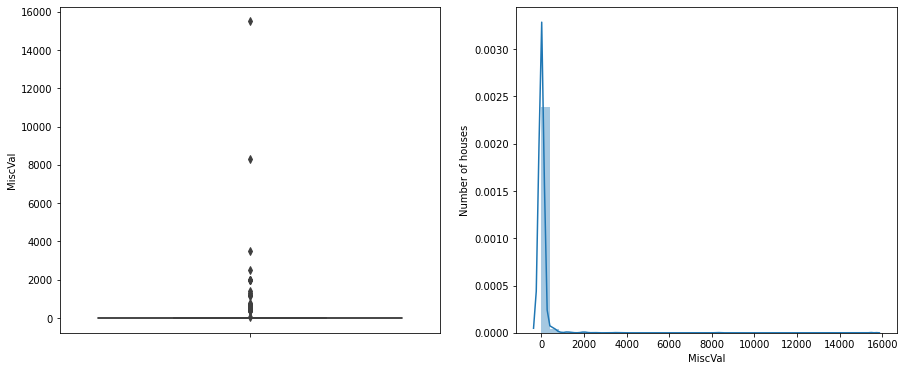

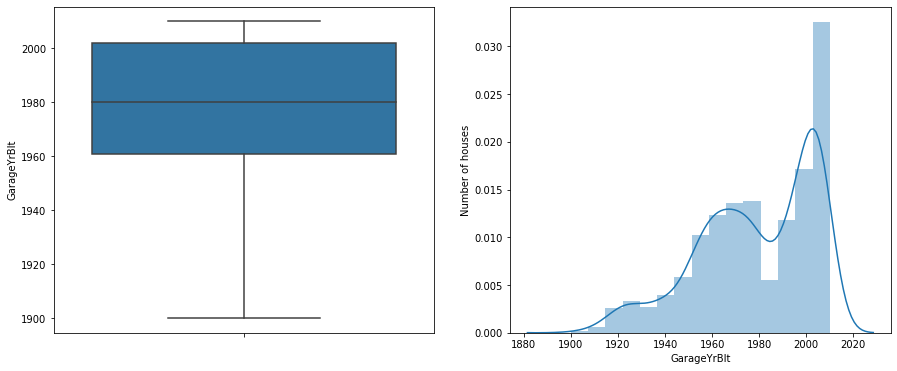

In [9]:
# Dist and outliers for continuous features
continuous = [var for var in numerical if var not in discrete and var not in ['Id', 'SalePrice']]
# continuous
for var in continuous:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = sns.boxplot(y=train[var])
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = sns.distplot(train[var].dropna())
    fig.set_ylabel('Number of houses')
    fig.set_xlabel(var)

    plt.show()

In [271]:
X_train, X_test, y_train, y_test = train_test_split(train, train.SalePrice, test_size=0.2,
                                                    random_state=43)
X_train.pop(target), X_test.pop(target)

y_train, y_test = np.log(y_train), np.log(y_test)

In [295]:
X_train = train.copy()
y_train = np.log(X_train.pop(target))

X_test = test.copy()


In [296]:
# Dealing with missing values in continuous
# If most of the values are 0, then create seperate boolean column to indicate if 0, and replace the 0 values with median, then apply transformation

drop = True
keep_outliers = True
sensitivity = 2.8
for var in continuous:
    
#     plt.figure(figsize=(20,6))
#     plt.subplot(1, 4, 1)
#     fig = sns.boxplot(y=X_train[var])
#     fig.set_title('')
#     fig.set_ylabel(var)
    
#     plt.subplot(1, 4, 2)
#     fig = sns.distplot(X_train[var].dropna())
#     fig.set_ylabel('Number of houses')
#     fig.set_xlabel(var)
    
    if ((X_train[var] == 0).sum() / X_train.shape[0]) > 0.3:
        X_train[var + 'Is0'] = X_train[var] == 0
        X_test[var + 'Is0'] = X_test[var] == 0
        if drop:
            X_train.pop(var), X_test.pop(var)
            continue
        else:
            mean = X_train[var][X_train[var] != 0].mean()
            X_train.loc[:, var] = X_train.loc[:, var].replace(0, mean)
            X_test.loc[:, var] = X_test.loc[:, var].replace(0, mean)
        
    
    transformer = PowerTransformer()
    transformer.fit(X_train[[var]])
    X_train[var], X_test[var] = transformer.transform(X_train[[var]]).flatten(), transformer.transform(X_test[[var]]).flatten()

        
        
#     plt.subplot(1, 4, 3)
#     fig = sns.boxplot(y=X_train[var])
#     fig.set_title('after')
#     fig.set_ylabel(var)
        
    if not keep_outliers:
        mean, std = X_train[var].mean(), X_train[var].std()
        z_score = (X_train[var] - mean) / std
        X_train[var] = np.clip(X_train[var], - sensitivity * z_score, sensitivity * z_score)
        
#     plt.subplot(1, 4, 4)
#     fig = sns.boxplot(y=X_train[var])
#     fig.set_ylabel('Number of houses after')
#     fig.set_xlabel(var)

#     plt.show()

/home/amine/miniconda3/envs/dev/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [297]:
# Missing values in continuous variables
# add variable indicating missingness + median imputation
for df in [X_train, X_test]:
    for var in ['LotFrontage', 'GarageYrBlt']:
        df[var+'_NA'] = np.where(df[var].isnull(), 1, 0)
        df[var].fillna(X_train[var].median(), inplace=True) 

# for df in [X_train, X_test]:
#     df.MasVnrArea.fillna(X_train.MasVnrArea.median(), inplace=True)

In [298]:
# Missing values in categorical data

# Adding missing label
for df in [X_train, X_test]:
    for var in categorical:
        df[var].fillna('Missing', inplace=True)

# Adding rare label
# treshold = 0.05
# def rare_imputation(variable):
#     # find frequent labels / discrete numbers
#     temp = X_train.groupby([variable])[variable].count()/np.float(len(X_train))
#     frequent_cat = [x for x in temp.loc[temp > treshold].index.values]
    
#     X_train.loc[:, variable] = np.where(X_train[variable].isin(frequent_cat), X_train[variable], 'Rare')
#     X_test.loc[:, variable] = np.where(X_test[variable].isin(frequent_cat), X_test[variable], 'Rare')
    
# # find unfrequent labels in categorical variables
# for var in categorical:
#     rare_imputation(var)


In [299]:
# Encoding
encoder = ce.TargetEncoder(cols=categorical)
encoder.fit(X_train, y_train)
X_train, X_test = encoder.transform(X_train), encoder.transform(X_test)

/home/amine/miniconda3/envs/dev/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [300]:
# Scaling
scaler = RobustScaler() # create an instance
scaler.fit(X_train)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

In [302]:
param_dist = {'objective':'reg:squarederror', 'n_estimators':1_000, 'reg_lambda': 0.1, 'max_depth':1, 'colsample_bynode': 0.5, }
model1 = XGBRegressor(**param_dist)
model1.fit(X_train, y_train, eval_set=[(X_train, y_train)], eval_metric="rmse")

model = model1

rmse()

sns.distplot(y_test)
sns.distplot(model.predict(X_test))

[0]	validation_0-rmse:8.07529
[1]	validation_0-rmse:5.65634
[2]	validation_0-rmse:3.96399
[3]	validation_0-rmse:2.78052
[4]	validation_0-rmse:1.95386
[5]	validation_0-rmse:1.37721
[6]	validation_0-rmse:0.97618
[7]	validation_0-rmse:0.69923
[8]	validation_0-rmse:0.51019
[9]	validation_0-rmse:0.38281
[10]	validation_0-rmse:0.29951
[11]	validation_0-rmse:0.24637
[12]	validation_0-rmse:0.21432
[13]	validation_0-rmse:0.19510
[14]	validation_0-rmse:0.18345
[15]	validation_0-rmse:0.17622
[16]	validation_0-rmse:0.17110
[17]	validation_0-rmse:0.16676
[18]	validation_0-rmse:0.16366
[19]	validation_0-rmse:0.16065
[20]	validation_0-rmse:0.15803
[21]	validation_0-rmse:0.15591
[22]	validation_0-rmse:0.15406
[23]	validation_0-rmse:0.15197
[24]	validation_0-rmse:0.14979
[25]	validation_0-rmse:0.14835
[26]	validation_0-rmse:0.14702
[27]	validation_0-rmse:0.14571
[28]	validation_0-rmse:0.14454
[29]	validation_0-rmse:0.14347
[30]	validation_0-rmse:0.14242
[31]	validation_0-rmse:0.14144
[32]	validation_0-

ValueError: Found input variables with inconsistent numbers of samples: [1459, 292]

In [248]:
def rmse(selected=False):
    if selected:
        train_pred, test_pred  = model.predict(X_train[selected]), model.predict(X_test[selected])
    else:
        train_pred, test_pred  = model.predict(X_train), model.predict(X_test)
        
    train_mse, test_mse = mean_squared_error(train_pred, y_train), mean_squared_error(test_pred, y_test), 
    return np.sqrt(train_mse), np.sqrt(test_mse) 

In [249]:
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)
rmse()

(0.05491613771547213, 0.14976467826797304)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization
from keras.regularizers import l2
from keras.optimizers import Adam


def _rmse(pred, true):
    mse = tf.keras.losses.mean_squared_error(pred, true)
    return tf.keras.backend.sqrt(mse)


def build_model(input_dim):
    initializer = tf.keras.initializers.GlorotNormal()
    model = Sequential()
#     model.add(Dense(256, input_dim=input_dim, kernel_initializer=initializer, activation='relu', kernel_regularizer=l2(0.2), bias_regularizer=l2(0.2)))
#     model.add(LayerNormalization())
    model.add(Dense(128, kernel_initializer=initializer, activation='relu', kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1)))
    model.add(LayerNormalization())
    model.add(Dense(64, kernel_initializer=initializer, activation='relu', kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1)))
    model.add(LayerNormalization())
    model.add(Dense(32, kernel_initializer=initializer, activation='relu', kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1)))
    model.add(LayerNormalization())
    model.add(Dense(16, kernel_initializer=initializer, activation='relu', kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1)))
    model.add(LayerNormalization())
    model.add(Dense(8, kernel_initializer=initializer, activation='relu', kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1)))
    model.add(LayerNormalization())
    model.add(Dense(4, kernel_initializer=initializer, activation='relu', kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1)))
    model.add(LayerNormalization())
    model.add(Dense(1, kernel_initializer=initializer))
    opt = Adam()
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=[_rmse])
    return model

model = build_model(X_train.shape[1])z
model.fit(X_train, y_train, epochs=1000, verbose=1, batch_size=128, validation_data=(X_test, y_test))

# Y_train, Y_test = Y_train * std + mean, Y_test * std + mean
rmse()


In [433]:
np.argsort((model.predict(X_test) - y_test).abs())

529      96
491     183
459      15
279      36
655     138
       ... 
326     184
440     215
1387      8
1323     73
61      216
Name: SalePrice, Length: 292, dtype: int64

In [445]:
y_test.iloc[184]

11.320553572322773

In [441]:
y_test.mean(), y_test.max(), y_test.min()

(12.026833745759888, 13.521139497361697, 11.112447898373103)

<AxesSubplot:xlabel='SalePrice'>

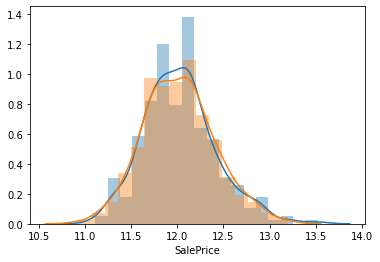

In [623]:
sns.distplot(y_test)
sns.distplot(model.predict(X_test))

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

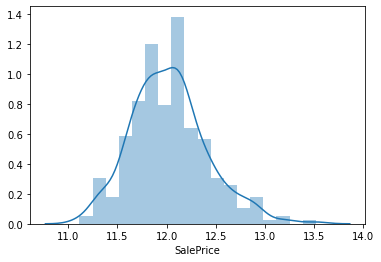

In [621]:
sns.distplot(y_test)
sns.distplot(model.predict(X_test))

In [ ]:
submission = pd.DataFrame({'Id': test_raw.Id, 'SalePrice': np.exp(_predict(X_test))})
submission.to_csv("FirstSubmission.csv", index=False)

# Model for 11.5 and 12.5

In [303]:
# X_train, y_train, X_test, y_test = pd.DataFrame(X_train), pd.Series(y_train.reset_index(drop=True)), pd.DataFrame(X_test), pd.Series(y_test.reset_index(drop=True))


X_train, y_train = pd.DataFrame(X_train), pd.Series(y_train.reset_index(drop=True))

In [304]:
train_filter = (y_train > 11.5) & (y_train < 12.5)  
# test_filter = (y_test > 11.5) & (y_test < 12.5)

# X_train_fil, y_train_fil, X_test_fil, y_test_fil = X_train[train_filter], y_train[train_filter], X_test[test_filter], y_test[test_filter]
X_train_fil, y_train_fil = X_train[train_filter], y_train[train_filter]


In [305]:
X_train_fil.shape, X_test_fil.shape

((1176, 88), (268, 88))

In [306]:
param_dist = {'objective':'reg:squarederror', 'n_estimators':1_000, 'reg_lambda': 0.1, 'max_depth':1, 'colsample_bynode': 0.2 }
model = XGBRegressor(**param_dist)
model.fit(X_train_fil, y_train_fil, eval_set=[(X_train_fil, y_train_fil)], eval_metric="rmse")


rmse()

sns.distplot(y_test_fil)
sns.distplot(model.predict(X_test_fil))

[0]	validation_0-rmse:8.04827
[1]	validation_0-rmse:5.63584
[2]	validation_0-rmse:3.94743
[3]	validation_0-rmse:2.76616
[4]	validation_0-rmse:1.94013
[5]	validation_0-rmse:1.36292
[6]	validation_0-rmse:0.96005
[7]	validation_0-rmse:0.68021
[8]	validation_0-rmse:0.48704
[9]	validation_0-rmse:0.35600
[10]	validation_0-rmse:0.26822
[11]	validation_0-rmse:0.21065
[12]	validation_0-rmse:0.17443
[13]	validation_0-rmse:0.15165
[14]	validation_0-rmse:0.13854
[15]	validation_0-rmse:0.13012
[16]	validation_0-rmse:0.12547
[17]	validation_0-rmse:0.12215
[18]	validation_0-rmse:0.12009
[19]	validation_0-rmse:0.11844
[20]	validation_0-rmse:0.11688
[21]	validation_0-rmse:0.11485
[22]	validation_0-rmse:0.11385
[23]	validation_0-rmse:0.11281
[24]	validation_0-rmse:0.11201
[25]	validation_0-rmse:0.11106
[26]	validation_0-rmse:0.10980
[27]	validation_0-rmse:0.10884
[28]	validation_0-rmse:0.10799
[29]	validation_0-rmse:0.10732
[30]	validation_0-rmse:0.10657
[31]	validation_0-rmse:0.10578
[32]	validation_0-

ValueError: feature_names mismatch: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87']
expected 13, 31, 78, 80, 19, 63, 24, 60, 40, 32, 79, 84, 38, 34, 3, 43, 18, 48, 83, 5, 28, 69, 2, 33, 54, 45, 87, 71, 23, 47, 59, 75, 57, 25, 49, 51, 12, 72, 11, 65, 22, 56, 62, 66, 26, 35, 7, 42, 64, 53, 16, 61, 46, 86, 77, 44, 70, 27, 30, 6, 81, 1, 0, 68, 29, 55, 20, 82, 4, 73, 50, 10, 14, 15, 76, 37, 52, 8, 36, 17, 67, 74, 21, 41, 85, 9, 58, 39 in input data
training data did not have the following fields: f11, f8, f64, f59, f17, f5, f10, f19, f46, f66, f18, f78, f31, f0, f35, f72, f38, f7, f27, f14, f33, f81, f80, f9, f15, f62, f55, f43, f65, f67, f49, f21, f24, f54, f25, f69, f44, f68, f76, f3, f47, f75, f60, f48, f12, f58, f6, f1, f42, f23, f32, f28, f87, f84, f50, f52, f26, f39, f22, f45, f85, f2, f51, f13, f30, f86, f82, f57, f36, f37, f73, f74, f63, f71, f4, f29, f34, f16, f40, f83, f70, f61, f53, f77, f79, f56, f41, f20

In [283]:
train_pred, test_pred  = model.predict(X_train_fil), model.predict(X_test_fil)

train_mse, test_mse = mean_squared_error(train_pred, y_train_fil), mean_squared_error(test_pred, y_test_fil), 
print(np.sqrt(train_mse), np.sqrt(test_mse))

0.058628162357502046 0.09208989910943464


In [307]:
model1, model

(XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=0.5, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None),
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=0.2, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel

In [311]:
def _predict(df):
    pred_m1_train, pred_m_train = model1.predict(df), model.predict(pd.DataFrame(df))
    
    train_filter = (pred_m1_train > 11.5) & (pred_m1_train < 12.5)
    
    predictions = pred_m1_train * (~train_filter) + pred_m_train * (train_filter)
    
    return predictions

In [294]:
train_pred, test_pred  = _predict(X_train_fil), _predict(X_test_fil)

train_mse, test_mse = mean_squared_error(train_pred, y_train_fil), mean_squared_error(test_pred, y_test_fil), 
print(np.sqrt(train_mse), np.sqrt(test_mse))


0.07122036207153934 0.12976611151452655
